# Regularization and Evaluation of Neural Networks

In [1]:
from sklearn.datasets import load_sample_images
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
%load_ext autoreload
%autoreload 2

## Learning Objectives

- use `keras` to code up a neural network model;
- explain dropout and early stopping as distinctive forms of regularization in neural networks;
- use wrappers inside `keras` to make models that can jibe with `sklearn`.

### From last time

In [2]:
digits = load_digits()
X = digits.data
y = digits.target

y_binary = y % 2

# A LOT OF STUDENTS GOT AN ERROR HERE
## Go to Google Colab
## Or use the following code that Jennifer Cobb recommended
X = digits.data.astype('float32') <br>
y = digits.target.astype('float32')

In [3]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X, y_binary, epochs=50, batch_size=10)

Epoch 1/50
180/180 [==============================] - 0s 995us/step - loss: 0.5734 - accuracy: 0.7284
Epoch 2/50
180/180 [==============================] - 0s 831us/step - loss: 0.2860 - accuracy: 0.8753
Epoch 3/50
180/180 [==============================] - 0s 746us/step - loss: 0.1917 - accuracy: 0.9193
Epoch 4/50
180/180 [==============================] - 0s 724us/step - loss: 0.1464 - accuracy: 0.9488
Epoch 5/50
180/180 [==============================] - 0s 742us/step - loss: 0.1204 - accuracy: 0.9560
Epoch 6/50
180/180 [==============================] - 0s 675us/step - loss: 0.0994 - accuracy: 0.9627
Epoch 7/50
180/180 [==============================] - 0s 860us/step - loss: 0.0892 - accuracy: 0.9638
Epoch 8/50
180/180 [==============================] - 0s 795us/step - loss: 0.0764 - accuracy: 0.9688
Epoch 9/50
180/180 [==============================] - 0s 756us/step - loss: 0.0684 - accuracy: 0.9705
Epoch 10/50
180/180 [==============================] - 0s 739us/step - loss: 0.065

*Divide the total number of observations by 10*

### Things to know:

- The data and labels in `fit()` need to be numpy arrays, not `pandas` dfs.
- Scaling your data will have a large impact on your model.
   > For our traditional input features, we would use a scaler object. For images, as long as the minimum value is 0, we can simply divide through by the maximum pixel intensity.

#### Getting data ready for modeling
**Preprocessing**:

- use train_test_split to create X_train, y_train, X_test, and y_test
- Split training data into pure_train and validation sets.
- Scale the pixel intensity to a value between 0 and 1.

Scaling our input variables will help speed up our neural network.

Since our minimum intensity is 0, we can normalize the inputs by dividing each value by the max value (16).

In [4]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y_binary, random_state=42, test_size=0.2)

X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train, random_state=42, test_size=0.2)

X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16 #Scale/Normalize our data

In [6]:
X_pure_train.shape

(1149, 64)

*We divde by 16 because we know it's a gray scale (0 = white, 16 = black) <br> So absolute black will become 1, and absolute white will become 0*

For activation, let's start with the familiar sigmoid function, and see how it performs.

In [5]:
model = Sequential()
# We will start with our trusty sigmoid function.
# What does input dimension correspond to?
model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD' ,
              # We use binary_crossentropy for a binary loss function
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output. To see
# only the metrics at the end of each epoch, set verbose=2.
results = model.fit(X_pure_train, y_pure_train, epochs=10, batch_size=100, verbose=1)

Epoch 1/10
12/12 [==============================] - 0s 1ms/step - loss: 0.7767 - accuracy: 0.4961
Epoch 2/10
12/12 [==============================] - 0s 877us/step - loss: 0.7625 - accuracy: 0.4961
Epoch 3/10
12/12 [==============================] - 0s 974us/step - loss: 0.7509 - accuracy: 0.4961
Epoch 4/10
12/12 [==============================] - 0s 998us/step - loss: 0.7414 - accuracy: 0.4961
Epoch 5/10
12/12 [==============================] - 0s 1ms/step - loss: 0.7334 - accuracy: 0.4961
Epoch 6/10
12/12 [==============================] - 0s 999us/step - loss: 0.7266 - accuracy: 0.4961
Epoch 7/10
12/12 [==============================] - 0s 1ms/step - loss: 0.7213 - accuracy: 0.4961
Epoch 8/10
12/12 [==============================] - 0s 1ms/step - loss: 0.7168 - accuracy: 0.4961
Epoch 9/10
12/12 [==============================] - 0s 1ms/step - loss: 0.7130 - accuracy: 0.4961
Epoch 10/10
12/12 [==============================] - 0s 959us/step - loss: 0.7100 - accuracy: 0.4961


*verbose means print out result in each iteration <br> notice how each iteration only takes 12 images <br> batch size means there are 100 batches with 12 observations in each batch size? MAYBE? Norm and Andrew go me confused<br> notice that our accuracy doesn't increase*

We can access the history of our model via `results.history`.
Use __dict__ to take a tour.

In [7]:
results.__dict__

{'validation_data': None,
 'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x7feb0ec9fbe0>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.7767447233200073,
   0.7625477910041809,
   0.7508957386016846,
   0.7413603663444519,
   0.7334471344947815,
   0.7266380786895752,
   0.7212827205657959,
   0.7167859077453613,
   0.712952733039856,
   0.7099708318710327],
  'accuracy': [0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434]},
 'params': {'verbose': 1, 'epochs': 10, 'steps': 12},
 'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

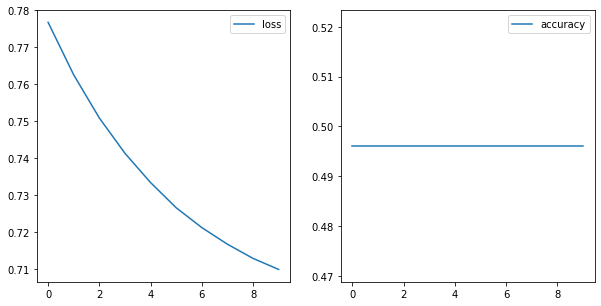

In [8]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

We have two plots above both relating to the quality of our model.  The left-hand plot is our loss. It uses the probabilities associated with our predictions to judge how well our prediction fits reality. We want it to decrease as far as possible.

The accuracy judges how well the predictions are after applying the threshold at the output layer.  We want accuracy to increase.

If we look at our loss, it is still decreasing. That is a signal that our model is **still learning**. If our model is still learning, we can allow it to get better by turning a few dials.

Let's:
- increase the number of epochs;
- change sigmoid activation in the hidden layers to ReLU; and
- decrease the batch size.

In [9]:
X_pure_train.shape[0]

1149

In [10]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64)) #We changed activation from sigmoid to relu
model.add(Dense(8, activation='relu')) #
model.add(Dense(1, activation='sigmoid')) #Leave last as sigmoid because it's a classification problem

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output.
results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=None, verbose=1)

Epoch 1/100
36/36 [==============================] - 0s 884us/step - loss: 0.7359 - accuracy: 0.4961
Epoch 2/100
36/36 [==============================] - 0s 832us/step - loss: 0.6912 - accuracy: 0.5013
Epoch 3/100
36/36 [==============================] - 0s 827us/step - loss: 0.6755 - accuracy: 0.5413
Epoch 4/100
36/36 [==============================] - 0s 873us/step - loss: 0.6657 - accuracy: 0.6066
Epoch 5/100
36/36 [==============================] - 0s 808us/step - loss: 0.6572 - accuracy: 0.6580
Epoch 6/100
36/36 [==============================] - 0s 868us/step - loss: 0.6485 - accuracy: 0.6849
Epoch 7/100
36/36 [==============================] - 0s 869us/step - loss: 0.6392 - accuracy: 0.7041
Epoch 8/100
36/36 [==============================] - 0s 894us/step - loss: 0.6288 - accuracy: 0.7241
Epoch 9/100
36/36 [==============================] - 0s 825us/step - loss: 0.6171 - accuracy: 0.7433
Epoch 10/100
36/36 [==============================] - 0s 946us/step - loss: 0.6041 - accura

36/36 [==============================] - 0s 745us/step - loss: 0.1571 - accuracy: 0.9382
Epoch 83/100
36/36 [==============================] - 0s 725us/step - loss: 0.1562 - accuracy: 0.9304
Epoch 84/100
36/36 [==============================] - 0s 872us/step - loss: 0.1548 - accuracy: 0.9330
Epoch 85/100
36/36 [==============================] - 0s 765us/step - loss: 0.1538 - accuracy: 0.9321
Epoch 86/100
36/36 [==============================] - 0s 635us/step - loss: 0.1527 - accuracy: 0.9330
Epoch 87/100
36/36 [==============================] - 0s 801us/step - loss: 0.1521 - accuracy: 0.9356
Epoch 88/100
36/36 [==============================] - 0s 775us/step - loss: 0.1505 - accuracy: 0.9356
Epoch 89/100
36/36 [==============================] - 0s 854us/step - loss: 0.1493 - accuracy: 0.9347
Epoch 90/100
36/36 [==============================] - 0s 794us/step - loss: 0.1474 - accuracy: 0.9417
Epoch 91/100
36/36 [==============================] - 0s 967us/step - loss: 0.1467 - accuracy: 

*We changed activation from sigmoid to relu in the first 2 layers <br> Leave last as sigmoid because it's a classification problem <br> `batch_size = None` means the batchsize will default to 32*

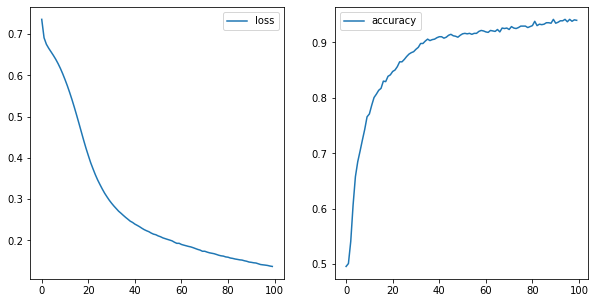

In [11]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

If we increase the learning rate to a very high number, we see that our model overshoots the minimum, and starts bouncing all around.

Epoch 1/30
115/115 [==============================] - 0s 774us/step - loss: 1.1493 - accuracy: 0.5091
Epoch 2/30
115/115 [==============================] - 0s 832us/step - loss: 1.0034 - accuracy: 0.4830
Epoch 3/30
115/115 [==============================] - 0s 861us/step - loss: 0.9506 - accuracy: 0.5057
Epoch 4/30
115/115 [==============================] - 0s 906us/step - loss: 0.9326 - accuracy: 0.5100
Epoch 5/30
115/115 [==============================] - 0s 774us/step - loss: 0.9551 - accuracy: 0.4996
Epoch 6/30
115/115 [==============================] - 0s 648us/step - loss: 0.9689 - accuracy: 0.5117
Epoch 7/30
115/115 [==============================] - 0s 689us/step - loss: 0.9796 - accuracy: 0.4996
Epoch 8/30
115/115 [==============================] - 0s 748us/step - loss: 1.0677 - accuracy: 0.4822
Epoch 9/30
115/115 [==============================] - 0s 686us/step - loss: 1.0311 - accuracy: 0.4917
Epoch 10/30
115/115 [==============================] - 0s 659us/step - loss: 1.057

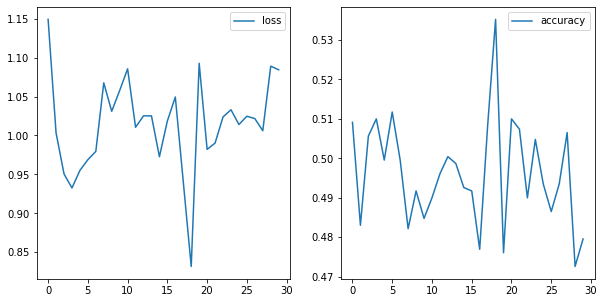

In [12]:
model = Sequential()

sgd = SGD(lr=9) #Create a new SGD object to finer tune our model. 
#Since learning rate = 9, we will be taking steps that are too big to converge
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                    epochs=30, batch_size=10, verbose=1)

relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy');

*If you want more fine control on the optimizer, you can create an optimizer object <br> Look at how we created an `SGD` object <br> We created a SGD with a learning rate of 9 to visualize how the loss function will jump from left to right because it cant converge since the learning rate is too big*

### Exercise

We have been looking only at our training set. Let's add in our validation set to the picture. Check the docstring for the `.fit()` method and add in our validation data.

Epoch 1/30
115/115 [==============================] - 0s 3ms/step - loss: 0.6654 - accuracy: 0.6066 - val_loss: 0.6169 - val_accuracy: 0.6250
Epoch 2/30
115/115 [==============================] - 0s 1ms/step - loss: 0.4750 - accuracy: 0.7972 - val_loss: 0.3593 - val_accuracy: 0.8611
Epoch 3/30
115/115 [==============================] - 0s 1ms/step - loss: 0.3010 - accuracy: 0.8825 - val_loss: 0.2760 - val_accuracy: 0.9028
Epoch 4/30
115/115 [==============================] - 0s 1ms/step - loss: 0.2421 - accuracy: 0.8973 - val_loss: 0.2289 - val_accuracy: 0.9028
Epoch 5/30
115/115 [==============================] - 0s 1ms/step - loss: 0.2002 - accuracy: 0.9208 - val_loss: 0.2084 - val_accuracy: 0.9236
Epoch 6/30
115/115 [==============================] - ETA: 0s - loss: 0.1833 - accuracy: 0.91 - 0s 1ms/step - loss: 0.1677 - accuracy: 0.9269 - val_loss: 0.2012 - val_accuracy: 0.9201
Epoch 7/30
115/115 [==============================] - 0s 1ms/step - loss: 0.1570 - accuracy: 0.9356 - val_

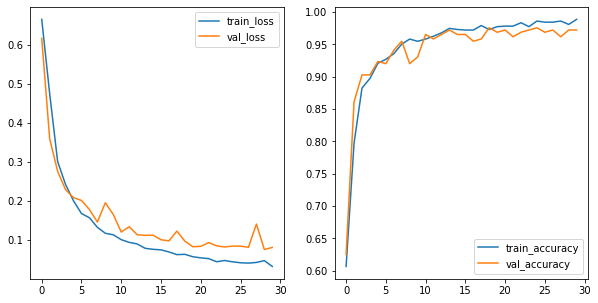

In [13]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


## YOUR CODE HERE
results = model.fit(X_pure_train, y_pure_train, 
                    epochs = 30, batch_size = 10, 
                    verbose = 1, validation_data = (X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

In [14]:
results.history['val_accuracy'][-1]

0.9722222089767456

In [15]:
results.__dict__

{'validation_data': None,
 'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x7feaf869b430>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.6654362082481384,
   0.47496432065963745,
   0.30097872018814087,
   0.24214859306812286,
   0.20020148158073425,
   0.16766422986984253,
   0.15698565542697906,
   0.1323239654302597,
   0.11714520305395126,
   0.11326237767934799,
   0.10075050592422485,
   0.09383023530244827,
   0.08978233486413956,
   0.0786529928445816,
   0.07599508762359619,
   0.0746782124042511,
   0.06929238140583038,
   0.06233372166752815,
   0.06319282948970795,
   0.056990738958120346,
   0.05414075776934624,
   0.05212699994444847,
   0.044190023094415665,
   0.04735289886593819,
   0.0439467653632164,
   0.04152272641658783,
   0.040685709565877914,
   0.042321886867284775,
   0.046986158937215805,
   0.0321025624871254],
  'accuracy': [0.6066144704818726,
   0.7972149848937988,
   0.8825065493583679,
   0.8973020

## Connecting with `sklearn`

The `keras.wrappers` submodule means that we can turn `keras` models into estimators that `sklearn` tools will recognize.

In [16]:
# This will throw an error.

cross_val_score(model, X_pure_train, y_pure_train)

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <tensorflow.python.keras.engine.sequential.Sequential object at 0x7feaf869b430> does not.

In [17]:
def build_model():
    model = Sequential()
    model.add(Dense(12, activation='relu', input_dim=64))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [18]:
keras_model = scikit_learn.KerasClassifier(build_model,
                                          epochs=50,
                                          batch_size=32,
                                          verbose=2)

In [19]:
type(keras_model)

tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier

In [20]:
cross_val_score(keras_model, X_pure_train, y_pure_train)

Epoch 1/50
29/29 - 0s - loss: 0.6949 - accuracy: 0.5822
Epoch 2/50
29/29 - 0s - loss: 0.6476 - accuracy: 0.6387
Epoch 3/50
29/29 - 0s - loss: 0.6048 - accuracy: 0.7106
Epoch 4/50
29/29 - 0s - loss: 0.5562 - accuracy: 0.7584
Epoch 5/50
29/29 - 0s - loss: 0.5111 - accuracy: 0.8128
Epoch 6/50
29/29 - 0s - loss: 0.4779 - accuracy: 0.8520
Epoch 7/50
29/29 - 0s - loss: 0.4523 - accuracy: 0.8803
Epoch 8/50
29/29 - 0s - loss: 0.4333 - accuracy: 0.8912
Epoch 9/50
29/29 - 0s - loss: 0.4164 - accuracy: 0.9097
Epoch 10/50
29/29 - 0s - loss: 0.4015 - accuracy: 0.9075
Epoch 11/50
29/29 - 0s - loss: 0.3710 - accuracy: 0.9162
Epoch 12/50
29/29 - 0s - loss: 0.3257 - accuracy: 0.9249
Epoch 13/50
29/29 - 0s - loss: 0.2794 - accuracy: 0.9217
Epoch 14/50
29/29 - 0s - loss: 0.2387 - accuracy: 0.9271
Epoch 15/50
29/29 - 0s - loss: 0.2153 - accuracy: 0.9260
Epoch 16/50
29/29 - 0s - loss: 0.1999 - accuracy: 0.9336
Epoch 17/50
29/29 - 0s - loss: 0.1905 - accuracy: 0.9271
Epoch 18/50
29/29 - 0s - loss: 0.1797 - 

Epoch 44/50
29/29 - 0s - loss: 0.0602 - accuracy: 0.9782
Epoch 45/50
29/29 - 0s - loss: 0.0586 - accuracy: 0.9771
Epoch 46/50
29/29 - 0s - loss: 0.0565 - accuracy: 0.9761
Epoch 47/50
29/29 - 0s - loss: 0.0534 - accuracy: 0.9804
Epoch 48/50
29/29 - 0s - loss: 0.0514 - accuracy: 0.9859
Epoch 49/50
29/29 - 0s - loss: 0.0500 - accuracy: 0.9804
Epoch 50/50
29/29 - 0s - loss: 0.0494 - accuracy: 0.9826
8/8 - 0s - loss: 0.1231 - accuracy: 0.9478
Epoch 1/50
29/29 - 0s - loss: 0.6369 - accuracy: 0.6094
Epoch 2/50
29/29 - 0s - loss: 0.5718 - accuracy: 0.7334
Epoch 3/50
29/29 - 0s - loss: 0.5346 - accuracy: 0.7780
Epoch 4/50
29/29 - 0s - loss: 0.5098 - accuracy: 0.8063
Epoch 5/50
29/29 - 0s - loss: 0.4903 - accuracy: 0.8096
Epoch 6/50
29/29 - 0s - loss: 0.4766 - accuracy: 0.8433
Epoch 7/50
29/29 - 0s - loss: 0.4611 - accuracy: 0.8542
Epoch 8/50
29/29 - 0s - loss: 0.4470 - accuracy: 0.8553
Epoch 9/50
29/29 - 0s - loss: 0.4344 - accuracy: 0.8705
Epoch 10/50
29/29 - 0s - loss: 0.4243 - accuracy: 0.87

array([0.94347829, 0.94782609, 0.94782609, 0.96086955, 0.94759828])

## Regularization

Does regularization make sense in the context of neural networks? <br/>

Yes! We still have all of the salient ingredients: a loss function, overfitting vs. underfitting, and coefficients (weights) that could get too large.

But there are now a few different flavors besides L1 and L2 regularization. (Note that L1 regularization is not common in the context of  neural networks.)

We'll add a few more layers to give regularization a better chance of making a difference!

*The more complex your model, the more overfit it will be <br> So maybe it's not good to have 50 layers with 50 neurons each*

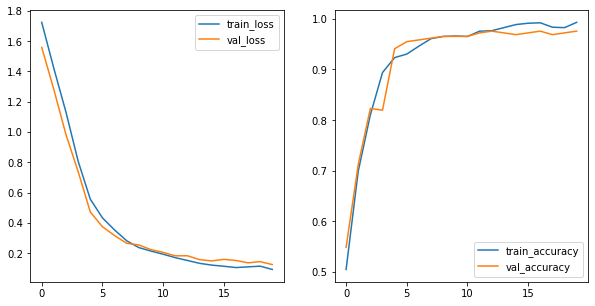

In [21]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))

# We can add L2 (or L1) regularization right into
# the layer with the kernel_regularizer parameter.

model.add(Dense(20, activation='relu',
                kernel_regularizer=l2(l2=0.05)))

# Note that there is also a bias_regularizer,
# but this tends to have less effect.

model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

*This is an apple to apple comparison with our previous model <br> EXCEPT this model has a regularization value (i.e. L2)*

Adding L2 to multiple layers:

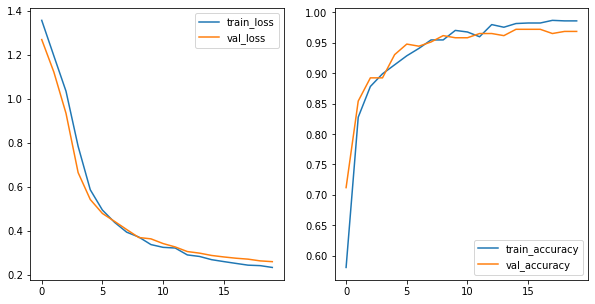

In [22]:
model = Sequential()
model.add(Dense(30, activation='relu',
                input_dim=64))
model.add(Dense(20, activation='relu',
                kernel_regularizer=l2(l2=0.01)))

model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(8, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(4, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

*We could add a regularizaton term for the first layer but you shouldn't*

### Dropout

We can also specify a dropout layer in keras, which randomly shuts off different nodes during training. This can help to prevent overfitting.

![drop_out](img/drop_out.png)

### Exercise

To add dropout to a `keras` network, simply add it as though it were a layer. It will apply to the immediately preceding layer.

Add Dropout to one or more layers below.

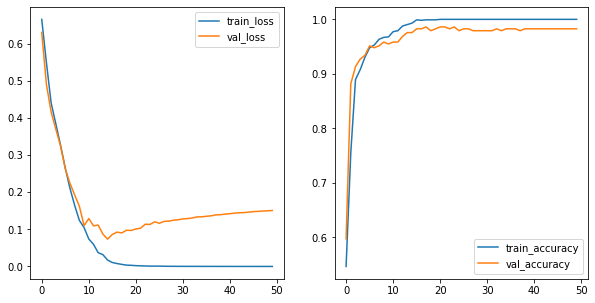

In [25]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=0,
                    validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

*Bad model because the loss doesn't converge to training set*

In [26]:
results.history['val_accuracy'][-1]

0.9826388955116272

### *After dropout*

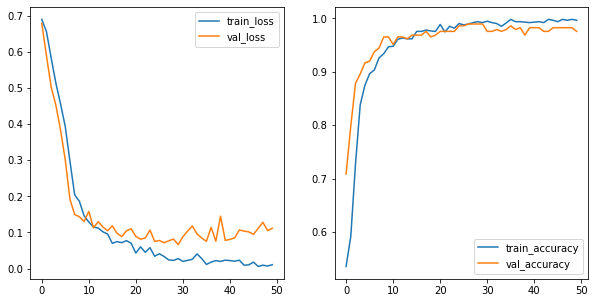

In [27]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(.2, input_shape=(20,))) #This drop will control just the layer before
model.add(Dense(12, activation='relu'))
model.add(Dropout(.2, input_shape=(12,))) #This drop will control just the layer before
model.add(Dense(12, activation='relu'))
model.add(Dropout(.2, input_shape=(12,))) #This drop will control just the layer before
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=0,
                    validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

### Early Stopping

We can also tell our neural network to stop once it stops realizing any gain.

Here we tell it to stop once the a very small positive change in the validation loss occurs:

Epoch 00011: early stopping


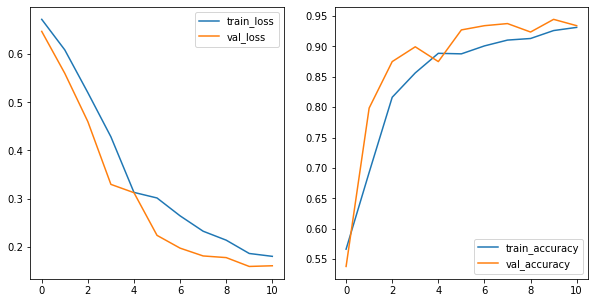

In [28]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           verbose=1,
                           mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

### Exercise

That probably stopped too early. We can specify the number of epochs in which it doesn't see decrease in the loss with the `patience` parameter. Modify the code below to include an Early Stop with a patience of 5 epochs.

Epoch 00004: early stopping


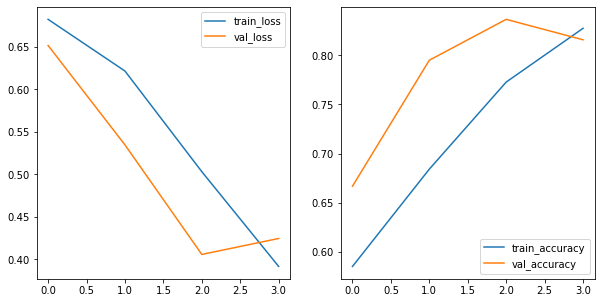

In [29]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object



# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=50, batch_size= 32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

*It was only set to the 4th epoch instead of running through all 50 epochs*

In [ ]:
results.history['val_accuracy'][-1]

## Multiclass Classification and Softmax

Now let's return to the problem of predicting digits 0 through 9.

In [ ]:
digits = load_digits()
X = digits.data
y = digits.target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)
X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train,
                     random_state=42, test_size=0.2)
X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

For a multiclass output, our neural net expects our target to be in a certain form.

In [ ]:
ohe = OneHotEncoder(sparse=False)
y_pure_train = ohe.fit_transform(y_pure_train.reshape(-1,1))
y_val = ohe.transform(y_val.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

In [ ]:
y_test

In [ ]:
# Model from above, but now with ten output neurons:

model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                   epochs=50, batch_size=10,
                   validation_data=(X_val, y_val))

$$\large \text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$$

The sofmax function outputs a number between 0 and 1 for each of our classes.  All of the probabilities of the classes sum up to 1.

The number of nodes in our output layer equals the number of categories in our dataset.

We also need a new loss function: **categorical crossentropy**, which calculates a separate loss for each label and then sums the results.

In [ ]:
history = results.history
training_loss = history['loss']
val_loss = history['val_loss']
training_accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))


sns.lineplot(x=list(range(len(training_loss))),
             y=training_loss, color='r', label='training', ax=ax1)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_loss, color='b', label='validation', ax=ax1)
sns.lineplot(x=list(range(len(training_loss))),
             y=training_accuracy, color='r', label='training',ax=ax2)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_accuracy, color='b', label='validation',ax=ax2)
ax1.legend();

In [ ]:
y_hat_test = np.argmax(model.predict(X_test), axis=-1)

In [ ]:
y_test_restore = ohe.inverse_transform(y_test)
confusion_matrix(y_test_restore, y_hat_test)

Wow, look at that performance!  

That is great, but remember, we were dealing with simple black and white images.  With color, our basic neural net will have less success.

We will explore more advanced tools in the coming days.
